C:\Users\dasar\AppData\Local\Temp\ipykernel_12012\3528834004.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [1/100], Loss: 0.2097, Time: 0.54s
Epoch [11/100], Loss: 0.0091, Time: 0.22s
Epoch [21/100], Loss: 0.0069, Time: 0.41s
Epoch [31/100], Loss: 0.0060, Time: 0.68s
Epoch [41/100], Loss: 0.0044, Time: 0.30s
Epoch [51/100], Loss: 0.0043, Time: 0.21s
Epoch [61/100], Loss: 0.0037, Time: 0.22s
Epoch [71/100], Loss: 0.0036, Time: 0.16s
Epoch [81/100], Loss: 0.0035, Time: 0.08s
Epoch [91/100], Loss: 0.0036, Time: 0.10s
RMSE: 3.3827
Normalized RMSE: 0.1492


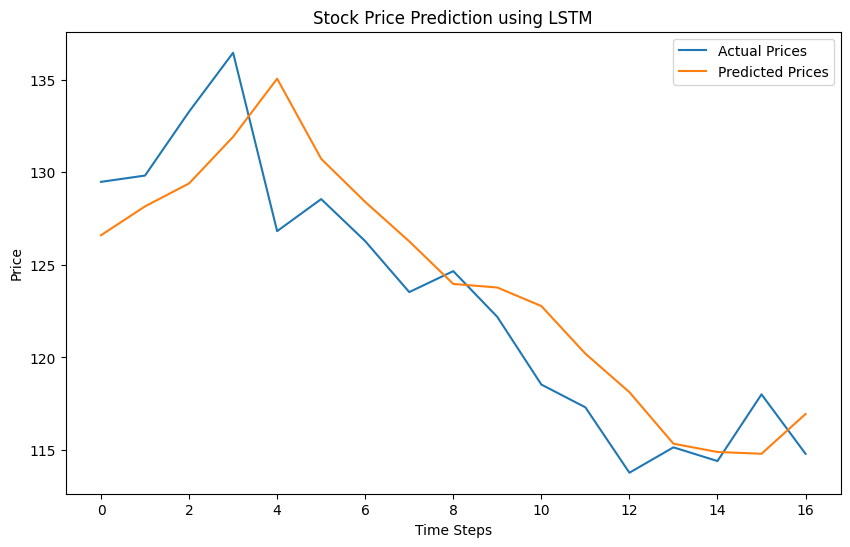

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import time

# Step 1: Load CSV and preprocess
data = pd.read_csv("AMZN_dataset.csv")
series = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Step 2: Split data into training and testing
train_size = int(len(series_scaled) * 0.8)
train_data, test_data = series_scaled[:train_size], series_scaled[train_size:]

# Step 3: Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_length = 30
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Step 4: DataLoader for batching
batch_size = 8
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#batch first=true is for easy formatting
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use the output from the last time step
#the output of the LSTM at the last time step is passed through a fully connected layer (self.fc) for further processing
# , such as making a prediction based on the final sequence state.   
        return output

input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 1
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
print(model)

# Step 6: Initialize loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train function
def train_model(model, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')

# Step 8: Train the LSTM model
train_model(model, train_loader, num_epochs=100)

# Step 9: Make predictions
model.eval()
with torch.no_grad():
    test_inputs = x_test
    predictions = model(test_inputs)

# Step 10: Inverse transform and plot
prediction_t = scaler.inverse_transform(predictions.detach().numpy())
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_test_actual = scaler.inverse_transform(y_test_np.reshape(-1, 1))

# Calculate RMSE in the original scale
rmse = np.sqrt(mean_squared_error(y_test_actual, prediction_t))

# Normalize RMSE by the range of the actual test values (max - min) in the original scale
range_test = y_test_actual.max() - y_test_actual.min()
normalized_rmse = rmse / range_test if range_test != 0 else 0  # Avoid division by zero

print(f'RMSE: {rmse:.4f}')
print(f'Normalized RMSE: {normalized_rmse:.4f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(prediction_t, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()
